In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import numpy as np
from numba import cuda
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.pyplot import figure

from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from tqdm.notebook import tqdm

#Importing the Libraries
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2, adamax_v2, adadelta_v2, adagrad_v2, rmsprop_v2
from keras.models import load_model
from keras.layers import LSTM, GRU
from keras.utils.vis_utils import plot_model
import keras
import pickle

from statsmodels.tsa.stattools import grangercausalitytests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Read Dataset**

In [ ]:
df = pd.read_csv(path+filename, parse_dates=['timestamp'])
df = df[df.timestamp > '2020-12-31 00:00:00']
#df = df[df.month == 1]
#df = df[df.day <= 4]
#df = df[df.time <= '12:00:00']
df.reset_index(inplace=True)
del df['index']
del df['ignore']
del df['close_time']
del df['quote_av']
del df['tb_quote_av']
del df['tb_base_av']
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp')
df

,timestamp,open,high,low,close,volume,trades
0,2020-12-31 00:15:00,754.67,755.84,749.57,752.83,4049.80544,4904
1,2020-12-31 00:30:00,752.84,753.85,747.55,749.27,3169.63010,3809
2,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353
3,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649
4,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622
...,...,...,...,...,...,...,...
35654,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418
35655,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571
35656,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599
35657,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.16490,3214


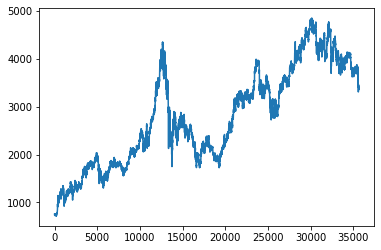

In [ ]:
df["open"].plot()

In [ ]:
df_test = pd.read_csv(path+filename, parse_dates=['timestamp'])
df_test = df_test[df_test.timestamp >= '2021-12-31 00:00:00']
#df_test = df_test[df_test.month == 1]
#df_test = df_test[df_test.day <= 4]
#df_test = df_test[df_test.time <= '12:00:00']
df_test.reset_index(inplace=True)
del df_test['index']
df_test.timestamp = pd.to_datetime(df_test.timestamp)
df_test.set_index('timestamp')
df_test

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2021-12-31 00:00:00,3709.55,3734.95,3705.67,3725.95,1604.5992,1640909699999,5.972598e+06,4796,903.0625,3.360867e+06,0
1,2021-12-31 00:15:00,3725.95,3730.98,3707.50,3711.22,584.8990,1640910599999,2.174863e+06,2523,231.2155,8.599313e+05,0
2,2021-12-31 00:30:00,3711.22,3713.41,3692.60,3696.38,695.8922,1640911499999,2.575595e+06,3074,299.8714,1.109848e+06,0
3,2021-12-31 00:45:00,3696.38,3709.91,3690.76,3701.01,649.6075,1640912399999,2.404285e+06,2830,300.2140,1.111084e+06,0
4,2021-12-31 01:00:00,3701.24,3706.57,3683.81,3696.38,785.4745,1640913299999,2.900369e+06,2902,328.6786,1.213924e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
680,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.1414,1641521699999,2.083888e+06,2418,345.1283,1.167087e+06,0
681,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.8899,1641522599999,2.156765e+06,2571,370.7408,1.253508e+06,0
682,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.7960,1641523499999,2.484534e+06,2599,296.2458,9.987078e+05,0
683,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.1649,1641524399999,3.044668e+06,3214,426.7326,1.437422e+06,0


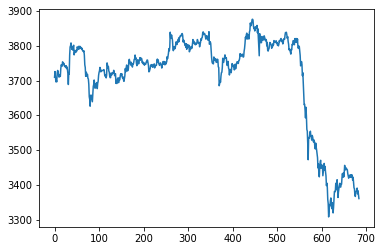

In [ ]:
df_test["open"].plot()

# **Prepro**

## **Get percentage change**

In [ ]:
df_test['pct_change'] = df_test['open'].pct_change()

df['pct_change'] = df['open'].pct_change()
df

,timestamp,open,high,low,close,volume,trades,pct_change
0,2020-12-31 00:15:00,754.67,755.84,749.57,752.83,4049.80544,4904,NaN
1,2020-12-31 00:30:00,752.84,753.85,747.55,749.27,3169.63010,3809,-0.002425
2,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353,-0.004888
3,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649,-0.004872
4,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622,-0.015560
...,...,...,...,...,...,...,...,...
35654,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418,0.002344
35655,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571,-0.004878
35656,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599,0.002593
35657,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.16490,3214,-0.003692


## **Differential**

In [ ]:
# diff 1
df_test['diff_1'] = df_test['open'].diff()
df_test['diff_2'] = df_test['open'].diff().diff()
df_test

df['diff_1'] = df['open'].diff()
df['diff_2'] = df['open'].diff().diff()
df

,timestamp,open,high,low,close,volume,trades,pct_change,diff_1,diff_2
0,2020-12-31 00:15:00,754.67,755.84,749.57,752.83,4049.80544,4904,NaN,NaN,NaN
1,2020-12-31 00:30:00,752.84,753.85,747.55,749.27,3169.63010,3809,-0.002425,-1.83,NaN
2,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353,-0.004888,-3.68,-1.85
3,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649,-0.004872,-3.65,0.03
4,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622,-0.015560,-11.60,-7.95
...,...,...,...,...,...,...,...,...,...,...
35654,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418,0.002344,7.93,7.49
35655,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571,-0.004878,-16.54,-24.47
35656,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599,0.002593,8.75,25.29
35657,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.16490,3214,-0.003692,-12.49,-21.24


## **Detrend**

In [ ]:
from scipy import signal

df_test['detrend'] = signal.detrend(df_test['open'].values)
df_test

df['detrend'] = signal.detrend(df['open'].values)
df

,timestamp,open,high,low,close,volume,trades,pct_change,diff_1,diff_2,detrend
0,2020-12-31 00:15:00,754.67,755.84,749.57,752.83,4049.80544,4904,NaN,NaN,NaN,-454.682965
1,2020-12-31 00:30:00,752.84,753.85,747.55,749.27,3169.63010,3809,-0.002425,-1.83,NaN,-456.601170
2,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353,-0.004888,-3.68,-1.85,-460.369375
3,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649,-0.004872,-3.65,0.03,-464.107580
4,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622,-0.015560,-11.60,-7.95,-475.795784
...,...,...,...,...,...,...,...,...,...,...,...
35654,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418,0.002344,7.93,7.49,-963.606072
35655,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571,-0.004878,-16.54,-24.47,-980.234277
35656,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599,0.002593,8.75,25.29,-971.572482
35657,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.16490,3214,-0.003692,-12.49,-21.24,-984.150687


## **Smoothing**

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

df_test['MA'] = df_test['open'].rolling(5, center=True).mean()
#df_test['loess_5'] = pd.DataFrame(lowess(df_test['open'], np.arange(len(df_test['open'])), frac=0.05)[:, 1], index=df_test['open'], columns=['open'])
#df_test['loess_15'] = pd.DataFrame(lowess(df_test['open'], np.arange(len(df_test['open'])), frac=0.15)[:, 1], index=df_test['open'], columns=['open'])

df['MA'] = df['open'].rolling(3, center=True).mean()
#df['loess_5'] = pd.DataFrame(lowess(df['open'], np.arange(len(df['open'])), frac=0.05)[:, 1], index=df['open'], columns=['open'])
#df['loess_15'] = pd.DataFrame(lowess(df['open'], np.arange(len(df['open'])), frac=0.15)[:, 1], index=df['open'], columns=['open'])
df

,timestamp,open,high,low,close,volume,trades,pct_change,diff_1,diff_2,detrend,MA
0,2020-12-31 00:15:00,754.67,755.84,749.57,752.83,4049.80544,4904,NaN,NaN,NaN,-454.682965,NaN
1,2020-12-31 00:30:00,752.84,753.85,747.55,749.27,3169.63010,3809,-0.002425,-1.83,NaN,-456.601170,752.223333
2,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353,-0.004888,-3.68,-1.85,-460.369375,749.170000
3,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649,-0.004872,-3.65,0.03,-464.107580,742.860000
4,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622,-0.015560,-11.60,-7.95,-475.795784,737.550000
...,...,...,...,...,...,...,...,...,...,...,...,...
35654,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418,0.002344,7.93,7.49,-963.606072,3382.443333
35655,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571,-0.004878,-16.54,-24.47,-980.234277,3382.490000
35656,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599,0.002593,8.75,25.29,-971.572482,3375.730000
35657,2022-01-07 02:45:00,3370.32,3376.55,3358.06,3360.44,904.16490,3214,-0.003692,-12.49,-21.24,-984.150687,3371.193333


## **Get profit status**

In [ ]:
df_test['profit'] = df_test['pct_change'].apply(lambda x: 1000 if x > 0.0016 else 0)

df['profit'] = df['pct_change'].apply(lambda x: 1000 if x > 0.0016 else 0)

## **Drop NaN**

In [ ]:
df_test.dropna(inplace=True)
#df_test['pct_change'] = df_test['pct_change'] + 2
#df_test['diff_1'] = df_test['diff_1'] + 2000
#df_test['diff_2'] = df_test['diff_2'] + 2000
#df_test['detrend'] = df_test['detrend'] + 2000
df_test.reset_index(inplace=True)
del df_test['index']

df.dropna(inplace=True)
#df['pct_change'] = df['pct_change'] + 2
#df['diff_1'] = df['diff_1'] + 2000
#df['diff_2'] = df['diff_2'] + 2000
#df['detrend'] = df['detrend'] + 2000
df.reset_index(inplace=True)
del df['index']

df

,timestamp,open,high,low,close,volume,trades,pct_change,diff_1,diff_2,detrend,MA,profit
0,2020-12-31 00:45:00,749.16,750.41,745.27,745.49,3700.55136,4353,-0.004888,-3.68,-1.85,-460.369375,749.170000,0
1,2020-12-31 01:00:00,745.51,746.92,728.00,733.91,15178.79561,12649,-0.004872,-3.65,0.03,-464.107580,742.860000,0
2,2020-12-31 01:15:00,733.91,737.23,729.84,733.24,6626.26655,7622,-0.015560,-11.60,-7.95,-475.795784,737.550000,0
3,2020-12-31 01:30:00,733.23,737.83,731.44,735.56,3855.62551,4980,-0.000927,-0.68,10.92,-476.563989,734.200000,0
4,2020-12-31 01:45:00,735.46,737.66,734.86,737.45,2325.74094,3225,0.003041,2.23,2.91,-474.422194,735.376667,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35651,2022-01-07 01:45:00,3382.67,3393.61,3381.98,3390.61,795.26020,2885,0.000130,0.44,-2.21,-971.447868,3385.166667,0
35652,2022-01-07 02:00:00,3390.60,3391.44,3373.45,3373.52,616.14140,2418,0.002344,7.93,7.49,-963.606072,3382.443333,1000
35653,2022-01-07 02:15:00,3374.06,3385.84,3374.06,3382.81,637.88990,2571,-0.004878,-16.54,-24.47,-980.234277,3382.490000,0
35654,2022-01-07 02:30:00,3382.81,3385.20,3366.56,3370.34,736.79600,2599,0.002593,8.75,25.29,-971.572482,3375.730000,1000


## **Set target**

In [ ]:
#Set Target Variable
target = 'close'
y_test = df_test[target]
y_train = df[target]

## **Set features**

### **Get features correlation to target using Granger**

In [ ]:
df_ = df.copy()
del df_['timestamp']

In [ ]:
maxlag=16
test='ssr_chi2test'
result = []

for c in tqdm(df_.columns):
  if c != target:
    test_result = grangercausalitytests(df_[[target, c]], maxlag=maxlag, verbose=False)
    p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
    min_p_value = np.min(p_values)
    result.append([c, min_p_value, p_values.index(min_p_value)+1])

granger = pd.DataFrame(result, columns=['feature', target, 'lag'])
granger.set_index('feature')
granger

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints 

,feature,open,lag
0,high,0.0000,1
1,low,0.0000,1
2,close,0.0000,1
3,volume,0.0000,1
4,trades,0.0000,1
5,pct_change,0.0000,2
6,diff_1,0.0000,2
7,diff_2,0.0000,1
8,detrend,0.0398,1
9,MA,0.0000,1


In [ ]:
features = []
for i, f in granger.iterrows():
  if f[target] <0.005:
    features.append(f['feature'])
features

['high',
 'low',
 'close',
 'volume',
 'trades',
 'pct_change',
 'diff_1',
 'diff_2',
 'MA',
 'profit']

## **Set train test data**

In [ ]:
#from tensorflow.keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

In [ ]:
trainX =  np.array(df[features])
testX =  np.array(df_test[features])

X_train = trainX.reshape(df[features].shape[0], 1, df[features].shape[1])
X_test = testX.reshape(df_test[features].shape[0], 1, df_test[features].shape[1])

# **Model**

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
lstm = Sequential()
lstm.add(LSTM(1210, input_shape=(1, trainX.shape[1]), use_bias=True, return_sequences=True, activation = "elu", bias_regularizer='l2'))
#lstm.add(Dropout(0.1))
lstm.add(LSTM(990, use_bias=True, return_sequences=True, activation = "elu", bias_regularizer='l2'))
#lstm.add(Dropout(0.1))
#lstm.add(LSTM(1100, return_sequences=True, use_bias=True, activation = "elu"))
#lstm.add(Dense(1100, use_bias=True, activation = "elu"))

lstm.add(Dense(770, use_bias=True, activation = "elu", bias_regularizer='l2'))
#lstm.add(Dense(330, use_bias=True, activation = "elu"))
lstm.add(Dense(99, use_bias=True, activation = "elu", bias_regularizer='l2'))
lstm.add(Dense(11, use_bias=True, activation = "elu", bias_regularizer='l2'))
lstm.add(Dense(1, activation = "elu"))

lstm.compile(loss="mean_absolute_error", optimizer="rmsprop")
#plot_model(lstm, show_shapes=True, show_layer_names=True)

## **Train**

In [ ]:
epoch = 100
bs = 64
patience_lr = 15
patience_es = patience_lr * 3

In [ ]:
filepath = path+"weight/Weight_ETHBUSD_5m.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-3, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=patience_es, verbose=1, mode='auto')
callbacks_list = [checkpoint, reduce_lr, early_stop]
    
history = lstm.fit(X_train, y_train, 
                    epochs=epoch, batch_size=bs, 
                    validation_data=(X_test[:], y_test[:]), 
                    verbose=1, shuffle=False, callbacks=callbacks_list)
                   

Epoch 1/100
557/558 [============================>.] - ETA: 0s - loss: 350.9260
Epoch 00001: val_loss improved from inf to 617.56586, saving model to /content/drive/MyDrive/Binance/generate_dataset/weight/Weight_ETHBUSD_5m.hdf5
558/558 [==============================] - 20s 30ms/step - loss: 350.8575 - val_loss: 617.5659 - lr: 0.0010
Epoch 2/100
557/558 [============================>.] - ETA: 0s - loss: 228.3041
Epoch 00002: val_loss improved from 617.56586 to 241.61649, saving model to /content/drive/MyDrive/Binance/generate_dataset/weight/Weight_ETHBUSD_5m.hdf5
558/558 [==============================] - 18s 32ms/step - loss: 228.3159 - val_loss: 241.6165 - lr: 0.0010
Epoch 3/100
558/558 [==============================] - ETA: 0s - loss: 186.0947
Epoch 00003: val_loss improved from 241.61649 to 38.28186, saving model to /content/drive/MyDrive/Binance/generate_dataset/weight/Weight_ETHBUSD_5m.hdf5
558/558 [==============================] - 18s 32ms/step - loss: 186.0947 - val_loss: 38.

## **Plot**

In [ ]:
plt.plot(history.history['loss'],'b',label='loss')
plt.plot(history.history['val_loss'],'r', label='val_loss')
plt.legend(loc="best")
plt.title('MODEL VAL LOSS')

## **Eval**

In [ ]:
lstm = load_model(filepath)
y_pred = lstm.predict(X_test)

y_predd = []
for y in y_pred:
  y_predd.append(y[0])

In [ ]:
plt.plot(y_predd[:], 'r', label='pred')
plt.plot(y_test[:], 'b', label='actual')
plt.legend(loc="best")

In [ ]:
df_eval = pd.DataFrame(y_test)
df_eval
df_eval ['pct_change_actual'] = df_eval ['open'].pct_change()
df_eval['profit_actual'] = df_eval['pct_change_actual'].apply(lambda x: 1000 if x > 0.0016 else 0)

df_eval ['open_pred'] = y_predd
df_eval['pct_change'] = df_eval['open_pred'].pct_change()
df_eval['profit'] = df_eval['pct_change'].apply(lambda x: 1000 if x > 0.0016 else 0)

df_eval

## **Accuracy profit**

In [ ]:
from sklearn.metrics import classification_report
print( classification_report(df_eval['profit_actual'], df_eval['profit']))